# Modelo de predicción de aprobación de creditos

#### La base de datos es del __U.S. Small Business Administration (SBA)__, una empresa que se dedica a la concesión de creditos a pequeños negocios, consiste en un histórico de características de los clientes que solicitaron un credito
#### Se va a construit un modelo para predecir la aprobación de un credito
##### Link de la BBDD 
[https://www.kaggle.com/datasets/mirbektoktogaraev/should-this-loan-be-approved-or-denied?select=SBAnational.csv]

### 1. Importamos y inspeccionamos la BBDD

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('datasets\_9loan_approval\SBAnational.csv')

In [3]:
# guardaremos esta base de datos para el análisis en Power BI (en el punto 7., la limpiaremos para poder hacer un mejor análisis)
P_BI = data

In [4]:
data.shape

(899164, 27)

In [5]:
data.columns = [e.lower() for e in data.columns]   
data.columns

Index(['loannr_chkdgt', 'name', 'city', 'state', 'zip', 'bank', 'bankstate',
       'naics', 'approvaldate', 'approvalfy', 'term', 'noemp', 'newexist',
       'createjob', 'retainedjob', 'franchisecode', 'urbanrural', 'revlinecr',
       'lowdoc', 'chgoffdate', 'disbursementdate', 'disbursementgross',
       'balancegross', 'mis_status', 'chgoffpringr', 'grappv', 'sba_appv'],
      dtype='object')

In [6]:
data = data.drop(['loannr_chkdgt', 'name', 'state', 'bank', 'franchisecode', 'approvaldate', 
                  'disbursementdate', 'approvalfy', 'chgoffdate', 'city', 'bankstate'], axis = 1)

In [7]:
data.columns = ['zip', 'industry', 'loan_term', 'employees', 'new/exist', 'jobs_created', 
                'jobs_retained', 'urban/rural', 'revlinecr', 'lowdoc', 'amount_disbursed', 
                'balancegross', 'loan_status', 'chargedoff_amount', 'grappv', 'sba_appv']

In [8]:
data.isna().sum()

zip                     0
industry                0
loan_term               0
employees               0
new/exist             136
jobs_created            0
jobs_retained           0
urban/rural             0
revlinecr            4528
lowdoc               2582
amount_disbursed        0
balancegross            0
loan_status          1997
chargedoff_amount       0
grappv                  0
sba_appv                0
dtype: int64

In [9]:
data = data.dropna()

In [10]:
data.head(3)

,zip,industry,loan_term,employees,new/exist,jobs_created,jobs_retained,urban/rural,revlinecr,lowdoc,amount_disbursed,balancegross,loan_status,chargedoff_amount,grappv,sba_appv
0,47711,451120,84,4,2.0,0,0,0,N,Y,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,46526,722410,60,2,2.0,0,0,0,N,Y,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,47401,621210,180,7,1.0,0,0,0,N,N,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"


In [11]:
lista_col_dollars = ['amount_disbursed','balancegross','chargedoff_amount','grappv','sba_appv']
for d in lista_col_dollars: 
    data[d] = data[d].str.replace('$', '').str.replace(',','')

### 2. Evaluamos los valores que deberían ser 'binarios'

In [12]:
# 1 = ruban, 2 = rural, 3 = undefined
data['urban/rural'].value_counts()

1    466767
0    318872
2    104299
Name: urban/rural, dtype: int64

In [13]:
# Para los créditos de menos de 150.000 dolares, pueden aplicar con un documetno más corto 
# (Y = yes, los demás son aplicaciones con más información)
data['lowdoc'].value_counts()

N    778761
Y    108009
0      1239
C       757
S       602
A       495
R        74
1         1
Name: lowdoc, dtype: int64

In [14]:
data['lowdoc'] = data['lowdoc'].str.replace('0', 'undefined')
data['lowdoc'] = data['lowdoc'].str.replace('C', 'undefined')
data['lowdoc'] = data['lowdoc'].str.replace('C', 'undefined')
data['lowdoc'] = data['lowdoc'].str.replace('S', 'undefined')
data['lowdoc'] = data['lowdoc'].str.replace('A', 'undefined')
data['lowdoc'] = data['lowdoc'].str.replace('R', 'undefined')
data['lowdoc'] = data['lowdoc'].str.replace('1', 'undefined')

In [15]:
data['lowdoc'].value_counts()

N            778761
Y            108009
undefined      3168
Name: lowdoc, dtype: int64

In [16]:
# 1 = existing business, 2 = new business, 0 = undefined
# existe hace más de 2 años...
data['new/exist'].value_counts()

1.0    638875
2.0    250038
0.0      1025
Name: new/exist, dtype: int64

In [17]:
# paid in full
# charged off
data['loan_status'].value_counts()

P I F     733502
CHGOFF    156436
Name: loan_status, dtype: int64

In [18]:
data['revlinecr'].value_counts()

N    417362
0    257431
Y    199893
T     15187
1        23
R        14
`        11
2         6
C         2
3         1
,         1
7         1
A         1
5         1
.         1
4         1
-         1
Q         1
Name: revlinecr, dtype: int64

In [19]:
data['revlinecr'] = data['revlinecr'].str.replace('0', 'undefined')
data['revlinecr'] = data['revlinecr'].str.replace('T', 'undefined')
data['revlinecr'] = data['revlinecr'].str.replace('1', 'undefined')
data['revlinecr'] = data['revlinecr'].str.replace('R', 'undefined')
data['revlinecr'] = data['revlinecr'].str.replace('`', 'undefined')
data['revlinecr'] = data['revlinecr'].str.replace('2', 'undefined')
data['revlinecr'] = data['revlinecr'].str.replace('C', 'undefined')
data['revlinecr'] = data['revlinecr'].str.replace('3', 'undefined')
data['revlinecr'] = data['revlinecr'].str.replace(',', 'undefined')
data['revlinecr'] = data['revlinecr'].str.replace('7', 'undefined')
data['revlinecr'] = data['revlinecr'].str.replace('A', 'undefined')
data['revlinecr'] = data['revlinecr'].str.replace('5', 'undefined')
data['revlinecr'] = data['revlinecr'].str.replace('.', 'undefined')
data['revlinecr'] = data['revlinecr'].str.replace('4', 'undefined')
data['revlinecr'] = data['revlinecr'].str.replace('-', 'undefined')
data['revlinecr'] = data['revlinecr'].str.replace('Q', 'undefined')

In [20]:
data['revlinecr'].value_counts()

N            417362
undefined    272683
Y            199893
Name: revlinecr, dtype: int64

In [21]:
data.shape

(889938, 16)

In [22]:
data = data.drop(data[data['new/exist'] == 0.0].index)
data = data.drop(data[data['lowdoc'] == 'undefined'].index)
data = data.drop(data[data['revlinecr'] == 'undefined'].index)

In [23]:
data.shape

(613723, 16)

### 2. Miramos el tipo de columnas que tenemos

In [24]:
data.dtypes

zip                    int64
industry               int64
loan_term              int64
employees              int64
new/exist            float64
jobs_created           int64
jobs_retained          int64
urban/rural            int64
revlinecr             object
lowdoc                object
amount_disbursed      object
balancegross          object
loan_status           object
chargedoff_amount     object
grappv                object
sba_appv              object
dtype: object

In [25]:
# Mirando los valores únicos, nos hemos dado cuenta que 'city' por ejemplo devuelve unos 3000...
#  por lo que decidimos eliminarlo ya que sino al pasarlo a numerico, nos agrandaria demasiado el dataset
for c in data.columns.tolist():         
    print(c, len(data[c].unique()))

zip 30200
industry 1305
loan_term 406
employees 529
new/exist 2
jobs_created 222
jobs_retained 315
urban/rural 3
revlinecr 2
lowdoc 2
amount_disbursed 106878
balancegross 8
loan_status 2
chargedoff_amount 60961
grappv 17229
sba_appv 31214


### 2.1 Valores categoricos

In [26]:
data.head(1)

,zip,industry,loan_term,employees,new/exist,jobs_created,jobs_retained,urban/rural,revlinecr,lowdoc,amount_disbursed,balancegross,loan_status,chargedoff_amount,grappv,sba_appv
0,47711,451120,84,4,2.0,0,0,0,N,Y,60000.00,0.00,P I F,0.00,60000.00,48000.00


In [27]:
# Estas columnas deberían ser numericas, y nos las marca como 'object'
data['amount_disbursed'] = pd.to_numeric(data['amount_disbursed'])
data['balancegross'] = pd.to_numeric(data['balancegross'])
data['chargedoff_amount'] = pd.to_numeric(data['chargedoff_amount'])
data['grappv'] = pd.to_numeric(data['grappv'])
data['sba_appv'] = pd.to_numeric(data['sba_appv'])

In [28]:
def getcat(data):
    categoric = data.loc[:,data.dtypes==object]
    return categoric
categorical = getcat(data)
categorical.head(3)

,revlinecr,lowdoc,loan_status
0,N,Y,P I F
1,N,Y,P I F
2,N,N,P I F


In [29]:
def convcat(categoric):
    categ = pd.get_dummies(categoric, columns=categoric.columns, drop_first=True)
    return categ
fin_cat = convcat(categorical)
fin_cat.head()

,revlinecr_Y,lowdoc_Y,loan_status_P I F
0,0,1,1
1,0,1,1
2,0,0,1
3,0,1,1
4,0,0,1


In [30]:
print(fin_cat.shape)
print(fin_cat.columns)

(613723, 3)
Index(['revlinecr_Y', 'lowdoc_Y', 'loan_status_P I F'], dtype='object')


In [31]:
print(categorical.shape)
print(categorical.columns)

(613723, 3)
Index(['revlinecr', 'lowdoc', 'loan_status'], dtype='object')


### 2.2 Numerical

In [32]:
numerical = data.drop(list(categorical.columns),axis = 1)
numerical.shape

(613723, 13)

In [33]:
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

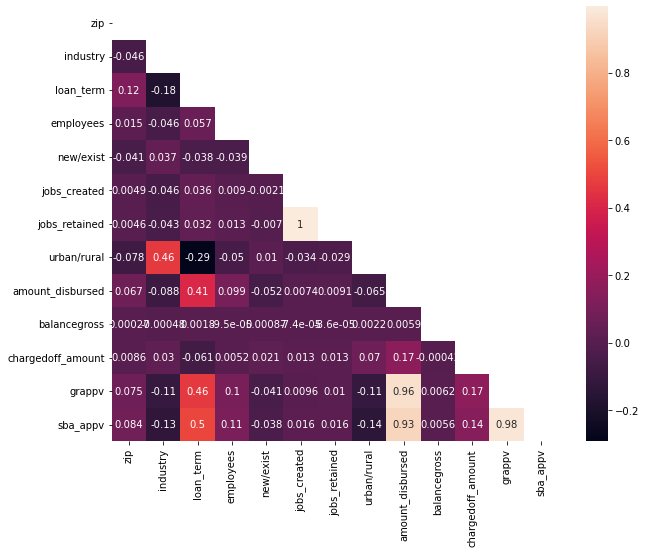

In [34]:
correlations_matrix = data.corr()
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

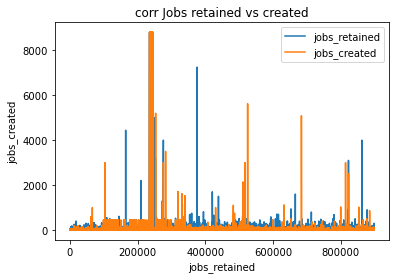

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(data['jobs_retained'], label='jobs_retained')
ax.plot(data['jobs_created'], label='jobs_created')
ax.set_xlabel('jobs_retained')
ax.set_ylabel('jobs_created')
ax.set_title('corr Jobs retained vs created')
ax.legend();

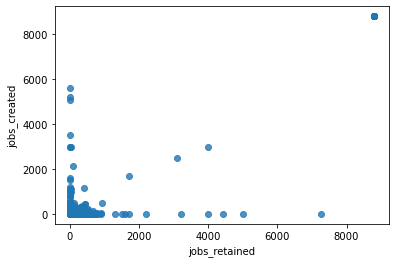

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(x=data['jobs_retained'], y=data['jobs_created'], alpha= 0.8)
ax.set_xlabel('jobs_retained')
ax.set_ylabel('jobs_created');

In [37]:
print('RETAINED')
print(data['jobs_retained'].value_counts())
print('------------------')
print('CREATED')
print(data['jobs_created'].value_counts())

RETAINED
0      314799
1       59893
2       50578
3       33470
4       26349
        ...  
247         1
675         1
281         1
260         1
198         1
Name: jobs_retained, Length: 315, dtype: int64
------------------
CREATED
0      452059
1       40210
2       34462
3       16230
4       11418
        ...  
252         1
183         1
210         1
166         1
860         1
Name: jobs_created, Length: 222, dtype: int64


### 3. Juntamos los valores numericos con los que eran categoricos

In [38]:
df = pd.concat([numerical, fin_cat], axis = 1)
print(df.head(3))
print(df.shape)

     zip  industry  loan_term  employees  new/exist  jobs_created  \
0  47711    451120         84          4        2.0             0   
1  46526    722410         60          2        2.0             0   
2  47401    621210        180          7        1.0             0   

   jobs_retained  urban/rural  amount_disbursed  balancegross  \
0              0            0           60000.0           0.0   
1              0            0           40000.0           0.0   
2              0            0          287000.0           0.0   

   chargedoff_amount    grappv  sba_appv  revlinecr_Y  lowdoc_Y  \
0                0.0   60000.0   48000.0            0         1   
1                0.0   40000.0   32000.0            0         1   
2                0.0  287000.0  215250.0            0         0   

   loan_status_P I F  
0                  1  
1                  1  
2                  1  
(613723, 16)


### 4. Outliers

In [39]:
df_fin = df

In [40]:
import scipy.stats as stats

In [41]:
# q1 = df.quantile(q=.25)
# q3 = df.quantile(q=.75)
# iqr = df.apply(stats.iqr)

# df_fin = df[~((df < (q1-1.5*iqr)) | (df > (q3+1.5*iqr))).any(axis=1)]

In [42]:
# df_fin.shape

### 5. Normalizamos

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

In [44]:
for c in df_fin[:-1]:
    df_fin[c] = StandardScaler().fit_transform(df_fin[c].values.reshape(-1, 1))
df_fin.head(5)

,zip,industry,loan_term,employees,new/exist,jobs_created,jobs_retained,urban/rural,amount_disbursed,balancegross,chargedoff_amount,grappv,sba_appv,revlinecr_Y,lowdoc_Y,loan_status_P I F
0,-0.166322,0.285709,-0.278550,-0.105999,1.642063,-0.039016,-0.046723,-1.060245,-0.465652,-0.00198,-0.212048,-0.432243,-0.408611,-0.694414,3.119533,0.469708
1,-0.204493,1.311934,-0.596437,-0.132587,1.642063,-0.039016,-0.046723,-1.060245,-0.540636,-0.00198,-0.212048,-0.509945,-0.484658,-0.694414,3.119533,0.469708
2,-0.176308,0.929119,0.993000,-0.066118,-0.608990,-0.039016,-0.046723,-1.060245,0.385416,-0.00198,-0.212048,0.449680,0.386326,-0.694414,-0.320561,0.469708
3,0.680879,-1.420769,-0.596437,-0.132587,-0.608990,-0.039016,-0.046723,-1.060245,-0.559382,-0.00198,-0.212048,-0.529371,-0.503670,-0.694414,3.119533,0.469708
4,-0.646599,-1.420769,1.787719,0.026938,-0.608990,-0.014513,-0.022228,-1.060245,0.167963,-0.00198,-0.212048,0.224343,0.451679,-0.694414,-0.320561,0.469708


### 6. Modeling

#### 6.1 Modelos

In [45]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,explained_variance_score

In [46]:
from sklearn.linear_model import Lasso       
from sklearn.linear_model import Ridge       
from sklearn.linear_model import ElasticNet  

In [47]:
df_fin.columns

Index(['zip', 'industry', 'loan_term', 'employees', 'new/exist',
       'jobs_created', 'jobs_retained', 'urban/rural', 'amount_disbursed',
       'balancegross', 'chargedoff_amount', 'grappv', 'sba_appv',
       'revlinecr_Y', 'lowdoc_Y', 'loan_status_P I F'],
      dtype='object')

In [48]:
df_fin.columns = ['zip', 'industry', 'loan_term', 'employees', 'new/exist',
       'jobs_created', 'jobs_retained', 'urban/rural', 'amount_disbursed',
       'balancegross', 'chargedoff_amount', 'grappv', 'sba_appv',
       'revlinecr_Y', 'lowdoc_Y', 'approval_decision']

In [49]:
from sklearn.model_selection import train_test_split as tts

x = df_fin.drop(columns = ['approval_decision'])
y = df_fin['approval_decision']

X_train, X_test, y_train, y_test = tts(x, y, test_size=0.2, random_state=42)
print(x.shape)
print(y.shape)

(613723, 15)
(613723,)


In [50]:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

rfr=RFR()
rfr.fit(X_train, y_train)

y_pred_rfr = rfr.predict(X_test)
ridge=Ridge()
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

elastic=ElasticNet()
elastic.fit(X_train, y_train)
y_pred_elastic = elastic.predict(X_test)

lasso=Lasso()
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

from sklearn.linear_model import LinearRegression as LinReg
linreg=LinReg()
linreg.fit(X_train, y_train)
y_pred_linreg=linreg.predict(X_test) 

from xgboost import XGBRegressor as XGBR
xgbr=XGBR()
xgbr.fit(X_train, y_train)
y_pred_xgbr = xgbr.predict(X_test) 

from lightgbm import LGBMRegressor as LGBMR
lgbmr=LGBMR()
lgbmr.fit(X_train, y_train)
y_pred_lgbmr = lgbmr.predict(X_test)

#### 6.2 Validando los modelos

In [51]:
models=[linreg, lasso, ridge, elastic, rfr, xgbr, lgbmr]
model_names=['linreg', 'lasso', 'ridge', 'elastic', 'rfr', 'xgbr', 'lgbmr']
preds=[y_pred_linreg, y_pred_lasso, y_pred_ridge, y_pred_elastic, y_pred_rfr, y_pred_xgbr, y_pred_lgbmr]

In [52]:
# R2
for i in range(len(models)):
    train_score=models[i].score(X_train, y_train)
    test_score=models[i].score(X_test, y_test)
    print ('Model: {}, train R2: {} -- test R2: {}'.format(model_names[i], train_score, test_score))

Model: linreg, train R2: 0.31062576744069403 -- test R2: 0.32059268988068246
Model: lasso, train R2: 0.0 -- test R2: -5.801976697084044e-06
Model: ridge, train R2: 0.3106257674058902 -- test R2: 0.32059266966985744
Model: elastic, train R2: 0.0 -- test R2: -5.801976697084044e-06
Model: rfr, train R2: 0.9940923024474078 -- test R2: 0.9571042643246596
Model: xgbr, train R2: 0.9668649828936818 -- test R2: 0.9582616619002361
Model: lgbmr, train R2: 0.9630427966738425 -- test R2: 0.9590589611604299


In [53]:
from sklearn.metrics import mean_squared_error as mse
# MSE
for i in range(len(models)):

    train_mse=mse(models[i].predict(X_train), y_train) 
    test_mse=mse(preds[i], y_test)

    print ('Model: {}, train MSE: {} -- test MSE: {}'.format(model_names[i], train_mse, test_mse))

Model: linreg, train MSE: 0.6899242447459772 -- test MSE: 0.6772359349063274
Model: lasso, train MSE: 1.0007978426820936 -- test MSE: 0.9968097989621324
Model: ridge, train MSE: 0.6899242447808089 -- test MSE: 0.6772359550525588
Model: elastic, train MSE: 1.0007978426820936 -- test MSE: 0.9968097989621324
Model: rfr, train MSE: 0.005912410965852648 -- test MSE: 0.04275864157022687
Model: xgbr, train MSE: 0.033161453637237534 -- test MSE: 0.04160494301932932
Model: lgbmr, train MSE: 0.0369866893603819 -- test MSE: 0.04081019191519023


In [54]:
# RMSE
for i in range(len(models)):

    train_rmse=mse(models[i].predict(X_train), y_train)**0.5 
    test_rmse=mse(preds[i], y_test)**0.5

    print ('Model: {}, train RMSE: {} -- test RMSE: {}'.format(model_names[i], train_rmse, test_rmse))

Model: linreg, train RMSE: 0.830616785735743 -- test RMSE: 0.8229434579035958
Model: lasso, train RMSE: 1.0003988418036547 -- test RMSE: 0.9984036252749348
Model: ridge, train RMSE: 0.8306167857567104 -- test RMSE: 0.8229434701439454
Model: elastic, train RMSE: 1.0003988418036547 -- test RMSE: 0.9984036252749348
Model: rfr, train RMSE: 0.0768922035440047 -- test RMSE: 0.20678162773860465
Model: xgbr, train RMSE: 0.18210286553823785 -- test RMSE: 0.2039728977568572
Model: lgbmr, train RMSE: 0.19231923814424262 -- test RMSE: 0.20201532594135088


In [55]:
# MAE
from sklearn.metrics import mean_absolute_error as mae
for i in range(len(models)):
    train_mae=mae(models[i].predict(X_train), y_train) 
    test_mae=mae(preds[i], y_test)

    print ('Model: {}, train MAE: {} -- test MAE: {}'.format(model_names[i], train_mae, test_mae))

Model: linreg, train MAE: 0.624493755574683 -- test MAE: 0.6219145658453874
Model: lasso, train MAE: 0.7702319845220554 -- test MAE: 0.7686973495049804
Model: ridge, train MAE: 0.6244938198020699 -- test MAE: 0.6219146286492782
Model: elastic, train MAE: 0.7702319845220554 -- test MAE: 0.7686973495049804
Model: rfr, train MAE: 0.01242214550562848 -- test MAE: 0.03394442826773982
Model: xgbr, train MAE: 0.028781070045984198 -- test MAE: 0.03242730481610124
Model: lgbmr, train MAE: 0.029754999108617036 -- test MAE: 0.031205265906012056


## 7 Para el análisis de Power BI adaptaremos un poco la BBDD

In [56]:
# guardaremos esta base de datos para el análisis en Power BI
P_BI.columns = [e.lower() for e in P_BI.columns]
P_BI.columns

Index(['loannr_chkdgt', 'name', 'city', 'state', 'zip', 'bank', 'bankstate',
       'naics', 'approvaldate', 'approvalfy', 'term', 'noemp', 'newexist',
       'createjob', 'retainedjob', 'franchisecode', 'urbanrural', 'revlinecr',
       'lowdoc', 'chgoffdate', 'disbursementdate', 'disbursementgross',
       'balancegross', 'mis_status', 'chgoffpringr', 'grappv', 'sba_appv'],
      dtype='object')

In [57]:
# eliminamos algunas columnas que ya hemos visto o no queremos incluir en el análisis
P_BI = P_BI.drop(['loannr_chkdgt', 'city', 'approvaldate', 'term', 'franchisecode', 
                  'chgoffdate', 'disbursementdate', 'disbursementgross', ], axis = 1)

In [58]:
P_BI = P_BI.dropna()
P_BI.columns

Index(['name', 'state', 'zip', 'bank', 'bankstate', 'naics', 'approvalfy',
       'noemp', 'newexist', 'createjob', 'retainedjob', 'urbanrural',
       'revlinecr', 'lowdoc', 'balancegross', 'mis_status', 'chgoffpringr',
       'grappv', 'sba_appv'],
      dtype='object')

In [59]:
# renombramos las columnas par una mejor presentación
P_BI.columns = ['Empresa', 'Estado empresa', 'Zip', 'Banco', 'Estado Banco', 'Industria', 'Año en que se aprovó',
                'Número de empleados', 'Nuevo o existente', 'Puestos de trabajo creados', 
                'Puestos de trabajo conservados', 'Urbano o rural', 'Línea de crédito renovable', 
                'Préstamo con poca documentación', 'Saldo bruto', 'Estado del préstamo', 'Importe deducido', 
                'Importe bruto del préstamo aprobado por el banco', 
                'Importe garantizado por la SBA del préstamo aprobado']
# Una línea de crédito renovable es una cuenta de crédito que le da la opción de pedir prestado hasta su límite de crédito
# Un préstamo con poca documentación es una hipoteca que requiere menos documentos

In [60]:
P_BI.head(1)

,Empresa,Estado empresa,Zip,Banco,Estado Banco,Industria,Año en que se aprovó,Número de empleados,Nuevo o existente,Puestos de trabajo creados,Puestos de trabajo conservados,Urbano o rural,Línea de crédito renovable,Préstamo con poca documentación,Saldo bruto,Estado del préstamo,Importe deducido,Importe bruto del préstamo aprobado por el banco,Importe garantizado por la SBA del préstamo aprobado
0,ABC HOBBYCRAFT,IN,47711,FIFTH THIRD BANK,OH,451120,1997,4,2.0,0,0,0,N,Y,$0.00,P I F,$0.00,"$60,000.00","$48,000.00"


In [61]:
# eliminamos el signo $ de las columnas
lista_col_dollars = ['Saldo bruto','Importe deducido','Importe bruto del préstamo aprobado por el banco','Importe garantizado por la SBA del préstamo aprobado']
for b in lista_col_dollars: 
    P_BI[b] = P_BI[b].str.replace('$', '').str.replace(',','')

In [62]:
# limpiamos los valores erroneos
P_BI['Préstamo con poca documentación'] = P_BI['Préstamo con poca documentación'].str.replace('0', 'undefined')
P_BI['Préstamo con poca documentación'] = P_BI['Préstamo con poca documentación'].str.replace('C', 'undefined')
P_BI['Préstamo con poca documentación'] = P_BI['Préstamo con poca documentación'].str.replace('C', 'undefined')
P_BI['Préstamo con poca documentación'] = P_BI['Préstamo con poca documentación'].str.replace('S', 'undefined')
P_BI['Préstamo con poca documentación'] = P_BI['Préstamo con poca documentación'].str.replace('A', 'undefined')
P_BI['Préstamo con poca documentación'] = P_BI['Préstamo con poca documentación'].str.replace('R', 'undefined')
P_BI['Préstamo con poca documentación'] = P_BI['Préstamo con poca documentación'].str.replace('1', 'undefined')

P_BI['Línea de crédito renovable'] = P_BI['Línea de crédito renovable'].str.replace('0', 'undefined')
P_BI['Línea de crédito renovable'] = P_BI['Línea de crédito renovable'].str.replace('T', 'undefined')
P_BI['Línea de crédito renovable'] = P_BI['Línea de crédito renovable'].str.replace('1', 'undefined')
P_BI['Línea de crédito renovable'] = P_BI['Línea de crédito renovable'].str.replace('R', 'undefined')
P_BI['Línea de crédito renovable'] = P_BI['Línea de crédito renovable'].str.replace('`', 'undefined')
P_BI['Línea de crédito renovable'] = P_BI['Línea de crédito renovable'].str.replace('2', 'undefined')
P_BI['Línea de crédito renovable'] = P_BI['Línea de crédito renovable'].str.replace('C', 'undefined')
P_BI['Línea de crédito renovable'] = P_BI['Línea de crédito renovable'].str.replace('3', 'undefined')
P_BI['Línea de crédito renovable'] = P_BI['Línea de crédito renovable'].str.replace(',', 'undefined')
P_BI['Línea de crédito renovable'] = P_BI['Línea de crédito renovable'].str.replace('7', 'undefined')
P_BI['Línea de crédito renovable'] = P_BI['Línea de crédito renovable'].str.replace('A', 'undefined')
P_BI['Línea de crédito renovable'] = P_BI['Línea de crédito renovable'].str.replace('5', 'undefined')
P_BI['Línea de crédito renovable'] = P_BI['Línea de crédito renovable'].str.replace('.', 'undefined')
P_BI['Línea de crédito renovable'] = P_BI['Línea de crédito renovable'].str.replace('4', 'undefined')
P_BI['Línea de crédito renovable'] = P_BI['Línea de crédito renovable'].str.replace('-', 'undefined')
P_BI['Línea de crédito renovable'] = P_BI['Línea de crédito renovable'].str.replace('Q', 'undefined')

P_BI = P_BI.drop(P_BI[P_BI['Nuevo o existente'] == 0.0].index)
P_BI = P_BI.drop(P_BI[P_BI['Préstamo con poca documentación'] == 'undefined'].index)
P_BI = P_BI.drop(P_BI[P_BI['Línea de crédito renovable'] == 'undefined'].index)

In [63]:
P_BI['Estado del préstamo'] = P_BI['Estado del préstamo'].str.replace('P I F', 'Pagado')
P_BI['Estado del préstamo'] = P_BI['Estado del préstamo'].str.replace('CHGOFF', 'Impago')

In [64]:
P_BI['Estado del préstamo'].value_counts()

Pagado    501366
Impago    110855
Name: Estado del préstamo, dtype: int64

In [65]:
P_BI.dtypes

Empresa                                                  object
Estado empresa                                           object
Zip                                                       int64
Banco                                                    object
Estado Banco                                             object
Industria                                                 int64
Año en que se aprovó                                     object
Número de empleados                                       int64
Nuevo o existente                                       float64
Puestos de trabajo creados                                int64
Puestos de trabajo conservados                            int64
Urbano o rural                                            int64
Línea de crédito renovable                               object
Préstamo con poca documentación                          object
Saldo bruto                                              object
Estado del préstamo                     

In [66]:
P_BI['Saldo bruto'] = pd.to_numeric(P_BI['Saldo bruto'])
P_BI['Importe deducido'] = pd.to_numeric(P_BI['Importe deducido'])
P_BI['Importe bruto del préstamo aprobado por el banco'] = pd.to_numeric(P_BI['Importe bruto del préstamo aprobado por el banco'])
P_BI['Importe garantizado por la SBA del préstamo aprobado'] = pd.to_numeric(P_BI['Importe garantizado por la SBA del préstamo aprobado'])

In [67]:
### Cambiamos el número identificador de la Industria por la misma...
L = []

for e in list(P_BI['Industria']):
    L.append(str(e))

In [68]:
def industria(df):
    lnew = []
    for e in L:
        if e[0:2] == '11':
            lnew.append('Agriculture, forestry, fishing and hunting')
        elif e[0:2] == '21':
            lnew.append('Mining, quarrying, and oil and gas extraction')
        elif e[0:2] == '22':
            lnew.append('Utilities')
        elif e[0:2] == '23':
            lnew.append('Construcción')
        elif e[0:2] == '31':
            lnew.append('Manufacturing')
        elif e[0:2] == '33':
            lnew.append('Manufacturing')
        elif e[0:2] == '42':
            lnew.append('Wholesale trade')
        elif e[0:2] == '44':
            lnew.append('Retail trade')
        elif e[0:2] == '45':
            lnew.append('Retail trade')
        elif e[0:2] == '48':
            lnew.append('Transportation and warehousing')
        elif e[0:2] == '49':
            lnew.append('Transportation and warehousing')
        elif e[0:2] == '51':
            lnew.append('Information')
        elif e[0:2] == '52':
            lnew.append('Finance and Insurance')
        elif e[0:2] == '53':
            lnew.append('Real estate and rental and leasing')
        elif e[0:2] == '54':
            lnew.append('Professional, scientific, and technical services')
        elif e[0:2] == '55':
            lnew.append('Management of companies and enterprises')
        elif e[0:2] == '56':
            lnew.append('Administrative')
        elif e[0:2] == '61':
            lnew.append('Educational services')
        elif e[0:2] == '62':
            lnew.append('Healthcare')
        elif e[0:2] == '71':
            lnew.append('Arts, entertainment, and recreation')
        elif e[0:2] == '72':
            lnew.append('Acomodation and Food services')
        elif e[0:2] == '81':
            lnew.append('Other services')
        elif e[0:2] == '92':
            lnew.append('Public administration')
        else:
            lnew.append('No especifica')

    return lnew

In [69]:
len(L) == len(industria(P_BI))

True

In [70]:
P_BI = P_BI.assign(Insudtria_nom = industria(P_BI))

In [71]:
P_BI = P_BI.drop(['Industria'], axis = 1)

In [72]:
# En último lugar, guardamos la BBDD en archivo CSV
P_BI.to_csv('dataset_aprovacióncréditos_PowerBi')